In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from graph_generation import create_ER
from models import GCN, GCNEmbed
from train import Trainer
from embedding import Embedding

import torch
device = torch.device('cuda')

# Prepare graphs dataset

In [3]:
N = 300 # Graph nodes number
Num_grafi_per_tipo = 100 

p_er = 0.02   # Probability for edge creation Erdos-Renyi graph
grafi_0 = create_ER(N, p_er, Num_grafi_per_tipo)

p_er = 0.6
grafi_1 = create_ER(N, p_er, Num_grafi_per_tipo)

Mean connectivity for each node:
5.968
Mean connectivity for each node:
179.455


In [4]:
dataset_grafi_nx = grafi_0 + grafi_1
len(dataset_grafi_nx)

200

In [5]:
dataset_labels = np.array([0]*len(grafi_0) + [1]*len(grafi_1))

# Load Model

In [6]:
hidden_channels = 64

In [7]:
model = GCN(hidden_channels=hidden_channels)
model.to(device)
print(model)

GCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


# Train model on dataset

In [8]:
trainer = Trainer(model, learning_rate=0.01, epochs=200, batch_size=150)

In [9]:
trainer.load_dataset(dataset_grafi_nx, dataset_labels, percentage_train=0.7)


100%|████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:23<00:00,  8.60it/s]

Step 1:
Number of graphs in the current batch: 140
DataBatch(x=[42000, 1], edge_index=[2, 3997688], y=[140], batch=[42000], ptr=[141])



In [10]:
trainer.launch_training()

runs/lr-0.01_epochs300_bs150/29Apr_01-18-56


# Take embedding layer and run on whole dataset

In [11]:
embed_model = GCNEmbed(model)
embed_model = embed_model.to(device)

In [12]:
from torch_geometric.loader import DataLoader
whole_data = trainer.dataset.dataset_pyg
all_data_loader = DataLoader(whole_data, batch_size=trainer.dataset.len_data, shuffle=False)

In [13]:
batch = next(iter(all_data_loader))
batch.x.shape

torch.Size([60000, 1])

In [14]:
res = embed_model(batch.x, batch.edge_index, batch.batch)

In [15]:
embeddings_array = res.cpu().detach().numpy()
embeddings_array.shape

(200, 64)

## T-sne

In [16]:
from sklearn.manifold import TSNE

In [17]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(embeddings_array)

/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


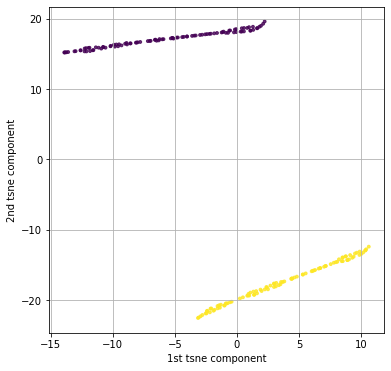

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.8, s=8, c=trainer.dataset.labels)
plt.xlabel('1st tsne component')
plt.ylabel('2nd tsne component')
plt.grid()
plt.show()

# Distance distribution

In [20]:
embeddings = Embedding(embeddings_array, trainer.dataset.labels)

In [22]:
embeddings.calc_coppie()

19900 possibili coppie


In [23]:
set(embeddings.coppie_labels)

{(0, 0), (0, 1), (1, 0), (1, 1)}

In [24]:
distances = embeddings.calc_distances()
len(distances)

19900

In [25]:
#ord_dists = sorted(distances, key=lambda x: x[1])

In [26]:
intra_dists = [d[0] for d in distances if d[1] == (0,0) or d[1] == (1,1)]
inter_dists = [d[0] for d in distances if d[1] == (1,0) or d[1] == (0,1)]

In [27]:
len(inter_dists), len(intra_dists)

(10000, 9900)

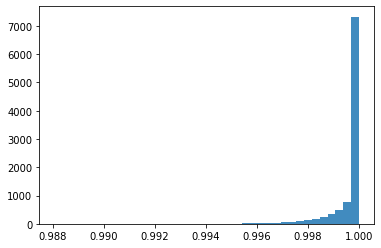

In [76]:
bins1 = np.linspace(min(intra_dists), 1, 40)
p1 = plt.hist(intra_dists, bins=bins1, alpha=0.85);

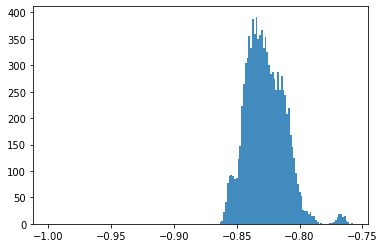

In [88]:
bins0 = np.linspace(-1, max(inter_dists), 170)
p2 = plt.hist(inter_dists, bins=bins0, alpha=0.85);